## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

In [10]:
!pip install torch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118



You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Looking in indexes: https://download.pytorch.org/whl/cu118


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Baseline-модель

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())

from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

CUDA available: True


Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Функция для подсчета числа параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cuda


In [4]:
class Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(Baseline, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=32 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
    
    def forward(self, x):
        # Прямой проход через сверточные слои
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        
        # Вытягивание в одномерный вектор
        x = x.view(x.size(0), -1)
        
        # Прямой проход через полносвязные слои
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

Files already downloaded and verified
Files already downloaded and verified


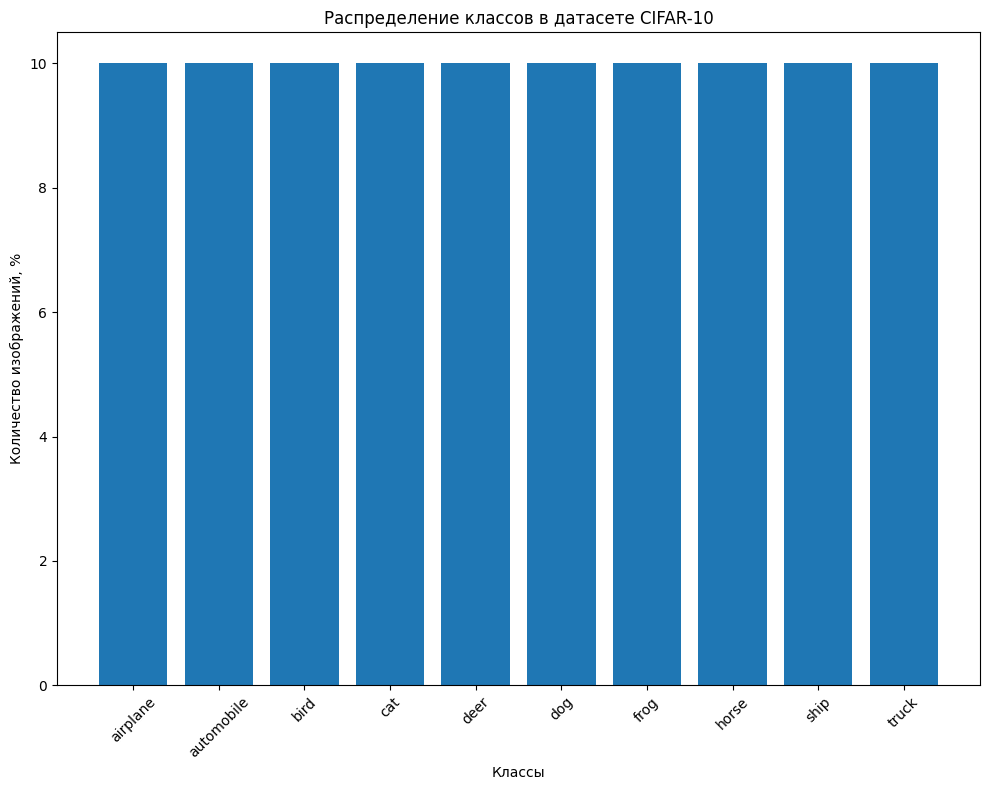

In [5]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

# Загрузим датасеты для train и test
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

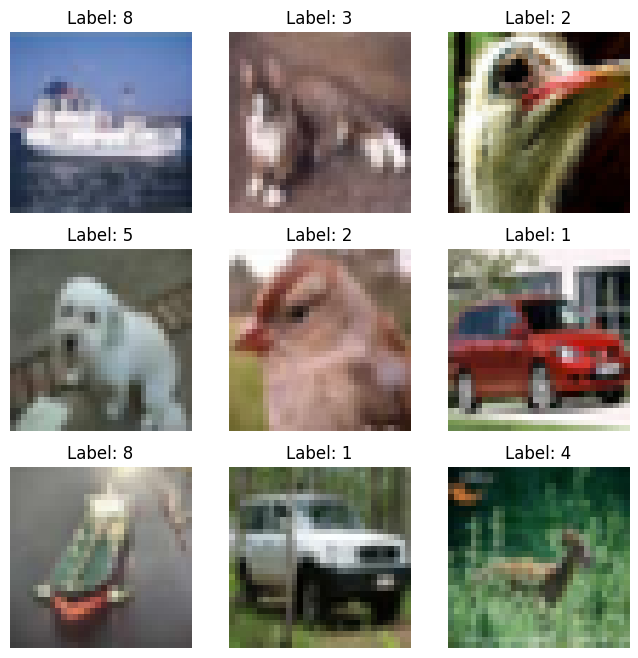

In [6]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  # Перевести изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Ответ: CIFAR-10 — включает 10 классов, по 6000 изображений на каждый класс. В этом случае датасет считается сбалансированным, так как каждый класс представлен равномерно.

Для сбалансированных датасетов подойдут следующие метрики:

    Accuracy (Точность): доля верных предсказаний от общего количества. При равномерном распределении классов эта метрика подходит для оценки.

    Precision, Recall и F1-Score (Точность, Полнота и F1-мера): их также можно рассматривать для анализа результатов, особенно при оценке отдельных классов. В данном случае это полезно для диагностики модели, но F1-score может быть избыточной метрикой для хорошо сбалансированных наборов.

Напишем функции train и test

In [7]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    # Перевод модели в режим обучения и на нужное устройство
    model.train()
    model = model.to(device)
    # Списки для хранения истории потерь и точности на каждом этапе
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        # Процесс обучения
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc='Train epoch {}/{}'.format(epoch + 1, epochs))
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            # Обнуление градиентов оптимизатора
            optimizer.zero_grad()
            # Прямой проход
            outputs = model(inputs)
            
            # Вычисление функции потерь
            loss = criterion(outputs, labels)

            # Обратный проход
            loss.backward()
            
            # Шаг оптимизации
            optimizer.step()
            # Сохранение значения потерь
            running_loss += loss.item()
            
            # Вычислите точность предсказания
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Обновление состояния tqdm с текущими значениями потерь и точности
            pbar.set_postfix({'loss': '{:.4f}'.format(running_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})
        
        # Сохранение потерь и точности на обучающей выборке    
        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)
        # Инициализация для проверки на валидационной выборке
        correct = 0
        total = 0
        test_loss = 0.0
        
        # Оценка на валидационной выборке
        # model.eval()  # Переключение модели в режим оценки ???
        
        pbar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100, desc='Val {}/{}'.format(epoch + 1, epochs))
        with torch.no_grad():
            for batch_idx, (inputs, labels) in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                # Прямой проход
                outputs = model(inputs)
                # Вычисление функции потерь
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                # Вычисление точности
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                # Обновление состояния tqdm с текущими значениями потерь и точности
                pbar.set_postfix({'loss': '{:.4f}'.format(test_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})
                
        # Сохранение значений потерь и точности на валидационной выборке
        val_loss_history.append(test_loss / len(val_loader))
        val_acc_history.append(correct / total)
        
        # # Возвращение модели в режим обучения ???
        # model.train()
        
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    # Переключаем модель в режим оценки
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Прямой проход
            outputs = model(inputs)
            # Вычисление функции потерь
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            # Вычисление точности предсказаний
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # Подсчёт средней потери и точности на тестовой выборке
    accuracy = correct / total
    average_loss = test_loss / len(test_loader)
    
    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?

In [8]:
train_size = int(0.8 * len(train_dataset))  # 80% данных для обучения
val_size = len(train_dataset) - train_size  # Остальные 20% данных для валидации

# Разделение на обучающий и валидационный датасеты
train_dataset, val_dataset = train_test_split(train_dataset, test_size=val_size, random_state=42, shuffle=True)


Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

In [9]:
# Гиперпараметры
learning_rate = 0.001  # Обычно для большинства задач с нейронными сетями начинается с такого значения
num_epochs = 10  # Количество эпох для тренировки. Может быть увеличено в зависимости от задачи и результатов
batch_size = 512  # Размер батча (обычно выбирается в зависимости от доступной памяти)

# Создание модели
model = Baseline()

print('Model params: ', count_parameters(model))

# Определяем функцию потерь и оптимизатор
criterion = torch.nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации (например, CIFAR-10)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Оптимизатор Adam, часто используется для обучения нейронных сетей

# Создание загрузчиков данных для тренировки, валидации и тестирования
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  268650


Обучите модель и постройте графики обучения

In [10]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)

Val 10/10: 100%|█████████████████████| 20/20 [00:00<00:00, 179.15it/s, loss=1.1834, accuracy=0.5825]


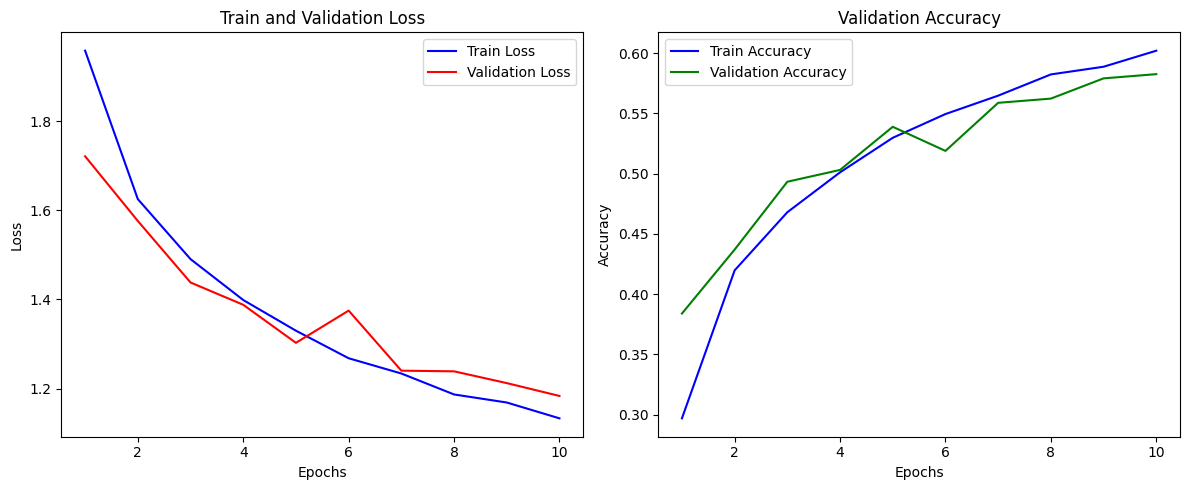

In [12]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Ответ: После 8 эпохи снижение потерь на тестовой выборке прекратилось, это может свидетельствовать о том, что модель начала переобучаться, что подтверждается тем, что Accuracy на тестовой выборке тоже перестала увеличиваться при том, что на тренировочной выборке обучение продолжилось. Это говорит, что на 8 эпохе обучения модель прекратила изучать полезные признаки в данных.

Оцените тестовую метрику на тестовых данных

In [13]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 1.1761
Test Accuracy: 0.5846


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов

Делаем аугментацию данных

In [14]:
# Преобразуем картинку в torch.Tensor
# Загрузка данных с аугментацией
transform_train = transforms.Compose([
    # transforms.Resize(64),  # Изменение размера изображения
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.RandomCrop(32, padding=4),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Преобразуем картинку в torch.Tensor
transform = transforms.ToTensor()

# Загрузим датасеты для train и test
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
train_size = int(0.8 * len(train_dataset))  # 80% данных для обучения
val_size = len(train_dataset) - train_size  # Остальные 20% данных для валидации

# Разделение на обучающий и валидационный датасеты
train_dataset, val_dataset = train_test_split(train_dataset, test_size=val_size, random_state=42, shuffle=True)

Добавляем аугментацию данных на лету в обучение

In [16]:
# import torch
# import torch.nn as nn
# from torchvision.transforms.functional import rotate
#
# class AugmentationLayer(nn.Module):
#     def __init__(self):
#         super(AugmentationLayer, self).__init__()
#
#     def forward(self, x):
#         # Случайное горизонтальное отражение
#         if torch.rand(1) > 0.5:
#             x = torch.flip(x, [3])  # flip по оси ширины (вправо-влево)
#
#         # Случайное вращение
#         if torch.rand(1) > 0.5:
#             angle = torch.randint(low=-10, high=10, size=(1,)).item()  # случайный угол от -10 до 10
#             x = rotate(x, angle)
#
#         # Возвращаем аугментированное изображение
#         return x

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import GaussianBlur

class AugmentationLayer(nn.Module):
    def __init__(self):
        super(AugmentationLayer, self).__init__()

    def forward(self, x):
        # Случайное горизонтальное отражение
        if torch.rand(1) > 0.5:
            x = torch.flip(x, [3])  # flip по оси ширины (вправо-влево)

        # # Случайное добавление размытия
        # if torch.rand(1) > 0.5:
        #     kernel_size = torch.randint(low=3, high=6, size=(1,)).item()  # случайный размер ядра
        #     if kernel_size % 2 == 0:  # проверка на четность
        #         kernel_size += 1  # делаем нечетным
        #     x = GaussianBlur(kernel_size=kernel_size, sigma=(0.1, 2.0))(x)

        import torchvision.transforms.functional as F
        # Случайное изменение положения (трансляция)
        if torch.rand(1) > 0.5:
            max_shift = 4  # максимум смещения в пикселях
            dx = torch.randint(low=-max_shift, high=max_shift + 1, size=(1,)).item()
            dy = torch.randint(low=-max_shift, high=max_shift + 1, size=(1,)).item()
            x = F.affine(x, angle=0, translate=(dx, dy), scale=1.0, shear=0)

        # Возвращаем аугментированное изображение
        return x


Структура улучшенной нейронной сети

In [17]:

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedCNN, self).__init__()
        self.augmentation_layer = AugmentationLayer()  # Добавляем слой аугментации

        # Блок 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.4)

        # Блок 2
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.5)

        # Блок 3
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.5)

        # Полносвязный слой
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # 128 каналов и размер 4x4 после 3-х пулингов
        self.bn7 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.augmentation_layer(x)  # Применяем аугментацию
        # Блок 1
        x = F.relu(self.bn1(self.conv1(x)))  # Используем F.relu без inplace=True
        x = F.relu(self.bn2(self.conv2(x)))  # Используем F.relu без inplace=True
        x = self.maxpool1(x)
        x = self.dropout1(x)

        # Блок 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.dropout2(x)

        # Блок 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.maxpool3(x)
        x = self.dropout3(x)

        # Полносвязный слой
        x = self.flatten(x)
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# Включение детектора аномалий
torch.autograd.set_detect_anomaly(True)

In [19]:
# Гиперпараметры
learning_rate = 1e-02  # Обычно для большинства задач с нейронными сетями начинается с такого значения
num_epochs = 180  # Количество эпох для тренировки. Может быть увеличено в зависимости от задачи и результатов
batch_size = 512  # Размер батча (обычно выбирается в зависимости от доступной памяти)

# Создание модели
model = ImprovedCNN()
# model = DenseNet(num_classes=10)
print('Model params: ', count_parameters(model))

# Определяем функцию потерь и оптимизатор
criterion = torch.nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации (например, CIFAR-10)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Оптимизатор Adam, часто используется для обучения нейронных сетей

# Создание загрузчиков данных для тренировки, валидации и тестирования
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  1270666


In [20]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)

Val 180/180: 100%|████████████████████| 20/20 [00:00<00:00, 26.94it/s, loss=0.4368, accuracy=0.8730]


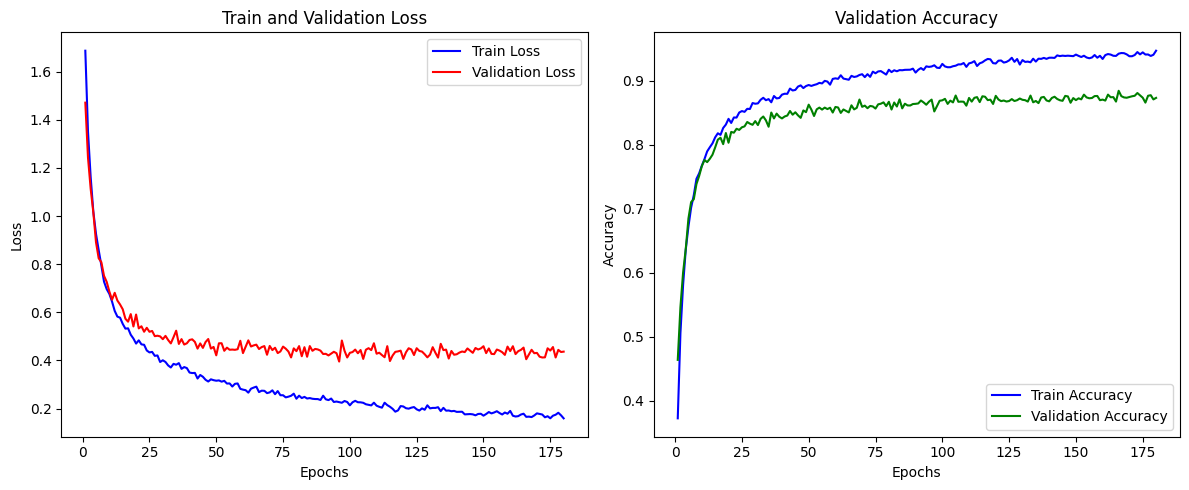

In [21]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.3238
Test Accuracy: 0.9061
